<font size="6"> **Portfolio Optimization** </font>

In [1]:
%%capture
%run 00_portopt_data.ipynb

In [2]:
import datetime as dt

from tqdm import tqdm

from src.mle_quant_utils import portopt_utils
from src.portfolio_opt import cvx_opt, cvx_opt_tc

In [63]:
N_DAYS_DELAY = cfg['backtesting']['n_days_delay']
OPT_CONST = cfg['backtesting']['opt_port']
LAMBDA_REG = OPT_CONST['lambda_reg']

In [67]:
print('n_days_delay:', N_DAYS_DELAY)
print('opt constraints params:', OPT_CONST)

n_days_delay: 2
opt constraints params: {'risk_aversion': '1e-6', 'min_mkt_cap': '1e8', 'lambda_reg': '0.5', 'risk_cap': '0.05', 'factor_max': '10.0', 'factor_min': '-10.0', 'weights_max': '0.55', 'weights_min': '-0.55'}


# Statistical Risk Model

In [4]:
risk_model.keys()

dict_keys(['idiosyncratic_var_vector', 'factor_var_vector', 'factor_betas', 'factor_returns'])

In [5]:
risk_model['factor_betas'].shape

(490, 20)

In [6]:
risk_model['factor_cov_matrix'] = np.diag(risk_model['factor_var_vector']['0'].values)
risk_model['factor_cov_matrix'].shape

(20, 20)

In [7]:
risk_model['idiosyncratic_var_vector'].shape

(490, 1)

# Portfolio Optimization

## No Transaction Costs

In [8]:
opt_engine_notc = cvx_opt.OptimalHoldingsRegualization(lambda_reg=LAMBDA_REG)

In [9]:
bkt_dates = test_dates.unique()
bkt_daily_returns = daily_returns.loc[bkt_dates].copy()
bkt_daily_adv = adv.loc[bkt_dates].copy()

In [10]:
res_simple_avg_combi = portopt_utils.run_backtesting(opt_engine_notc, B_alpha['avg_combi_alpha'], risk_model, bkt_daily_returns, bkt_daily_adv, n_days_delay=N_DAYS_DELAY)
pnl_simple_avg_combi, w_simple_avg_combi = res_simple_avg_combi

Opt portfolio: 100%|██████████| 149/149 [00:45<00:00,  3.28portfolio/s]


In [11]:
res_simple_ml = portopt_utils.run_backtesting(opt_engine_notc, B_alpha['ml_alpha'], risk_model, bkt_daily_returns, bkt_daily_adv, n_days_delay=N_DAYS_DELAY)
pnl_simple_ml, w_simple_ml = res_simple_ml

Opt portfolio: 100%|██████████| 149/149 [00:49<00:00,  3.01portfolio/s]


In [13]:
res_simple_1yrmon = portopt_utils.run_backtesting(opt_engine_notc, B_alpha['Momentum_1YR_Smoothed'], risk_model, bkt_daily_returns, bkt_daily_adv, n_days_delay=N_DAYS_DELAY)
pnl_simple_1yrmon, w_simple_1yrmon = res_simple_1yrmon

Opt portfolio: 100%|██████████| 149/149 [00:45<00:00,  3.25portfolio/s]


In [14]:
res_simple_5dmrev = portopt_utils.run_backtesting(opt_engine_notc, B_alpha['Mean_Reversion_Sector_Neutral_Smoothed'], risk_model, bkt_daily_returns, bkt_daily_adv, n_days_delay=N_DAYS_DELAY)
pnl_simple_5dmrev, w_simple_5dmrev = res_simple_5dmrev

Opt portfolio: 100%|██████████| 149/149 [00:45<00:00,  3.26portfolio/s]


In [15]:
pnl_simple_avg_combi['port_name'] = 'simple_avg_combi'
pnl_simple_5dmrev['port_name'] = 'Mean_Reversion_Sector_Neutral_Smoothed'
pnl_simple_1yrmon['port_name'] = 'Momentum_1YR_Smoothed'
pnl_simple_ml['port_name'] = 'simple_ml'
pnl_simple_app = pd.concat([ pnl_simple_1yrmon, pnl_simple_5dmrev, pnl_simple_avg_combi, pnl_simple_ml ], axis=0)

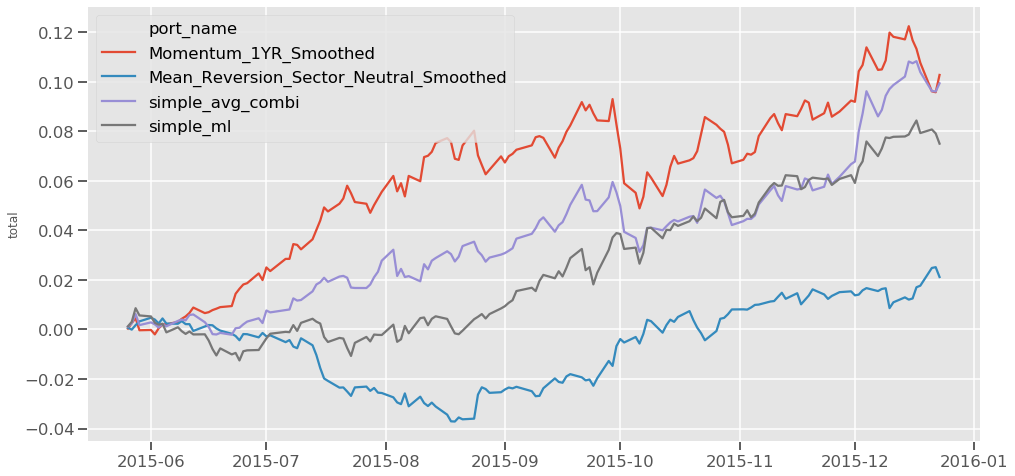

In [16]:
sns.lineplot(x=pnl_simple_app.index.values, y=pnl_simple_app['total'],  hue=pnl_simple_app['port_name'])
plt.show()

## Transaction Costs

In [17]:
opt_engine_tc = cvx_opt.OptimalHoldingsRegualization(lambda_reg=LAMBDA_REG)

In [18]:
res_tc_avg_combi = portopt_utils.run_backtesting(opt_engine_tc, B_alpha['avg_combi_alpha'], risk_model, bkt_daily_returns, bkt_daily_adv, n_days_delay=N_DAYS_DELAY)
pnl_tc_avg_combi, w_tc_avg_combi = res_tc_avg_combi

Opt portfolio: 100%|██████████| 149/149 [00:54<00:00,  2.75portfolio/s]


In [19]:
res_tc_ml = portopt_utils.run_backtesting(opt_engine_tc, B_alpha['ml_alpha'], risk_model, bkt_daily_returns, bkt_daily_adv, n_days_delay=N_DAYS_DELAY)
pnl_tc_ml, w_tc_ml = res_tc_ml

Opt portfolio: 100%|██████████| 149/149 [03:13<00:00,  1.30s/portfolio]


In [20]:
pnl_tc_avg_combi['port_name'] = 'tc_avg_combi'
pnl_tc_ml['port_name'] = 'tc_ml'

In [21]:
pnl_tc_app = pd.concat([ pnl_tc_avg_combi, pnl_tc_ml], axis=0)
pnl_simple_app = pd.concat([pnl_simple_avg_combi, pnl_simple_ml], axis=0)

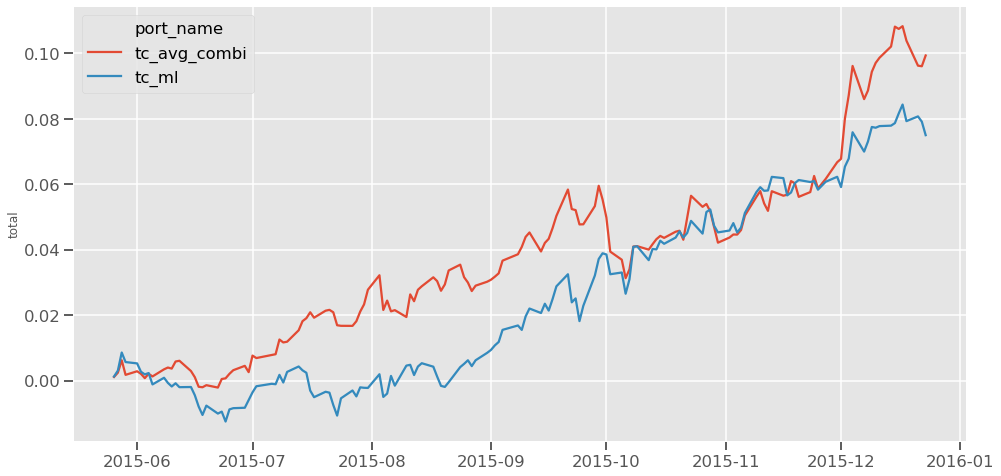

In [22]:
sns.lineplot(x=pnl_tc_app.index.values, y=pnl_tc_app['total'],  hue=pnl_tc_app['port_name'])
plt.show()

In [23]:
pnl_tc_stats = pnl_tc_app.groupby('port_name')['daily_pnl'].agg([np.mean, np.std])

In [24]:
pnl_tc_stats['sharpe_ratio'] = pnl_tc_stats['mean'] / pnl_tc_stats['std']

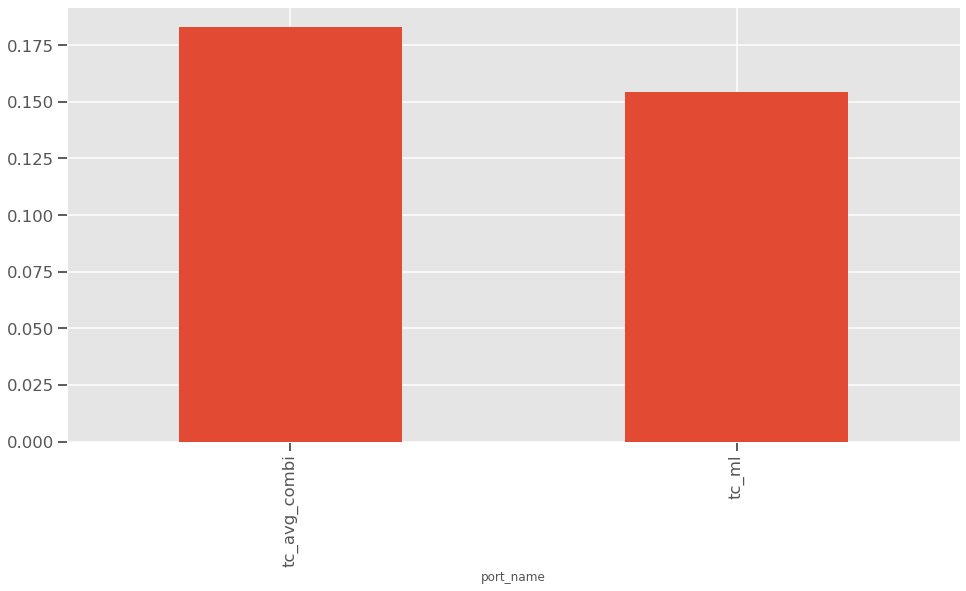

In [25]:
pnl_tc_stats['sharpe_ratio'].plot.bar()
plt.show()

# Write Results

## PnL Results

In [57]:
pnl_app = pd.concat([pnl_simple_ml, pnl_simple_avg_combi, pnl_tc_ml, pnl_tc_avg_combi], axis=0)
pd.concat([pnl_app.head(2), pnl_app.tail(2)])

,returns_date,daily_pnl,daily_transaction_cost,daily_total,total,port_name
date,,,,,,
2015-05-26 00:00:00+00:00,2015-05-28 00:00:00+00:00,0.001249,0.0,0.001249,0.001249,simple_ml
2015-05-27 00:00:00+00:00,2015-05-29 00:00:00+00:00,0.001819,0.0,0.001819,0.003068,simple_ml
2015-12-22 00:00:00+00:00,2015-12-24 00:00:00+00:00,-0.000182,0.0,-0.000182,0.096063,tc_avg_combi
2015-12-23 00:00:00+00:00,2015-12-28 00:00:00+00:00,0.003291,0.0,0.003291,0.099354,tc_avg_combi


In [58]:
pnl_app.to_csv(OUTPATH1 + OUTFILE1)

## Daily Portfolio Weights Dictionary

In [52]:
models_dict = {'simple_ml_avg_combi': w_simple_avg_combi,
               'simple_ml': w_simple_ml,
               'tc_avg_combi': w_tc_avg_combi,
               'tc_ml': w_tc_ml}

with open(OUTPATH2 + OUTFILE2, 'wb') as file:
    pickle.dump(models_dict, file)

## Portfolio Optimization Metadata

In [53]:
opt_metadata = {"alpha_model": RISK_MODEL_VERSION,
               "risk_model": MLALPHA_MODEL_VERSION,
                "backtesting_start_dt": test_start,
                "backtesting_end_dt": test_end
                "n_days_delay": n_days_delay
               }

with open(OUTPATH2 + f'{OUTFILE3}', 'wb') as file:
    pickle.dump(opt_metadata, file)

In [ ]:
pnl_simple_ml, w_simple_ml = res_simple_ml
pnl_simple_avg_combi, w_simple_avg_combi = res_simple_avg_combi

pnl_tc_ml, w_tc_ml = res_tc_ml
pnl_tc_avg_combi, w_tc_avg_combi = res_tc_avg_combi